In [1]:
import warnings
warnings.filterwarnings('ignore')

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:

class Operation:
    """Represents a graph node that performs a computation.

    An `Operation` is a node in a `Graph` that takes zero or
    more objects as input, and produces zero or more objects
    as output.
    """

    def __init__(self, input_nodes=[]):
        """Construct Operation
        """
        self.input_nodes = input_nodes

        # Initialize list of consumers (i.e. nodes that receive this operation's output as input)
        self.consumers = []

        # Append this operation to the list of consumers of all input nodes
        for input_node in input_nodes:
            input_node.consumers.append(self)

        # Append this operation to the list of operations in the currently active default graph
        _default_graph.operations.append(self)

    def compute(self):
        """Computes the output of this operation.
        "" Must be implemented by the particular operation.
        """
        pass


In [3]:
class add(Operation):
    """Returns x + y element-wise.
    """

    def __init__(self, x, y):
        """Construct add

        Args:
          x: First summand node
          y: Second summand node
        """
        self.string = '(' + x.string + '+' + y.string + ')'
        
        super().__init__([x, y])

    def compute(self, x_value, y_value):
        """Compute the output of the add operation

        Args:
          x_value: First summand value
          y_value: Second summand value
        """
        return x_value + y_value


class multiply(Operation):
    """Returns x * y element-wise.
    """

    def __init__(self, x, y):
        """Construct multiply

        Args:
          x: First multiplicand node
          y: Second multiplicand node
        """
        self.string = '(' + x.string + '*' + y.string + ')'
        
        super().__init__([x, y])

    def compute(self, x_value, y_value):
        """Compute the output of the multiply operation

        Args:
          x_value: First multiplicand value
          y_value: Second multiplicand value
        """
        return x_value * y_value

class matmul(Operation):
    """Multiplies matrix a by matrix b, producing a * b.
    """

    def __init__(self, a, b):
        """Construct matmul

        Args:
          a: First matrix
          b: Second matrix
        """
        self.string = ''
        super().__init__([a, b])

    def compute(self, a_value, b_value):
        """Compute the output of the matmul operation

        Args:
          a_value: First matrix value
          b_value: Second matrix value
        """
        return a_value.dot(b_value)

class sigmoid(Operation):
    """Returns the sigmoid of x element-wise.
    """

    def __init__(self, a):
        """Construct sigmoid

        Args:
          a: Input node
        """
        self.string = ''
        super().__init__([a])

    def compute(self, a_value):
        """Compute the output of the sigmoid operation

        Args:
          a_value: Input value
        """
        return 1 / (1 + np.exp(-a_value))



In [7]:
class placeholder:
    """Represents a placeholder node that has to be provided with a value
       when computing the output of a computational graph
    """

    def __init__(self, p):
        """Construct placeholder
        """
        self.consumers = []
        self.string = p
        #print(self.string)

        # Append this placeholder to the list of placeholders in the currently active default graph
        _default_graph.placeholders.append(self)


class Variable:
    """
    Represents a variable (i.e. an intrinsic, 
    changeable parameter of a computational graph).
    """

    def __init__(self, initial_value):
        """Construct Variable

        Args:
          initial_value: The initial value of this variable
        """
        self.string = str(initial_value)
        self.value = initial_value
        self.consumers = []
        #print(self.string)
        
        # Append this variable to the list of variables in the currently active default graph
        
        _default_graph.variables.append(self)


In [ ]:
class Graph:
    """Represents a computational graph
    """

    def __init__(self):
        """Construct Graph"""
        self.operations = []
        self.placeholders = []
        self.variables = []

    def as_default(self):
        global _default_graph
        _default_graph = self


import numpy as np


class Session:
    """Represents a particular execution of a computational graph.
    """

    def run(self, operation, feed_dict={}):
        """Computes the output of an operation

        Args:
          operation: The operation whose output we'd like to compute.
          feed_dict: A dictionary that maps placeholders to values for this session
        """

        # Perform a post-order traversal of the graph to bring the nodes into the right order
        nodes_postorder = traverse_postorder(operation)

        # Iterate all nodes to determine their value
        for node in nodes_postorder:

            if type(node) == placeholder:
                # Set the node value to the placeholder value from feed_dict
                node.output = feed_dict[node]
            elif type(node) == Variable:
                # Set the node value to the variable's value attribute
                node.output = node.value
            else:  # Operation
                # Get the input values for this operation from node_values
                node.inputs = [input_node.output for input_node in node.input_nodes]

                # Compute the output of this operation
                node.output = node.compute(*node.inputs)

            # Convert lists to numpy arrays
            if type(node.output) == list:
                node.output = np.array(node.output)

        # Return the requested node value
        return operation.output


def traverse_postorder(operation):
    """Performs a post-order traversal, returning a list of nodes
    in the order in which they have to be computed

    Args:
       operation: The operation to start traversal at
    """

    nodes_postorder = []

    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)

    recurse(operation)
    return nodes_postorder



In [ ]:
# Sigmoid and Matmul testing

In [12]:
# Create a new graph
Graph().as_default()

x = placeholder('a')
w = Variable([1, 1])
b = Variable(0)
p = sigmoid(add(matmul(w, x), b))

session = Session()
print(session.run(p, {
    x: [3, 2]
}))



0.9933071490757153


In [13]:
# Run the function manually
# Create a new graph
Graph().as_default()

# Create placeholder
#
a = placeholder('a')
b = placeholder('b')
c = placeholder('c')
d = placeholder('d')

# Create hidden node y
y = multiply(b, c)

# Create output node z
z = add(y, a)

J = multiply(d, z)

# Create Session object and run it by using runc method

session = Session()
output = session.run(J, {
    a: 5 , b: 1, c: 2 ,d: 3
})
print("J = d (a + bc)")
print("if a=5, b=1, c=2 ,d=3;")

print("Result =", output)



In [15]:
# Implementing node and digraph classes to draw a graph

class node():
    def __init__(self, name):
        self.name = name
        self.neighbors = [] # list of nodes (not just names)
        
    def neighbors_name(self):
        """
        info about neighbors names
        """
        return [node_s.name for node_s in self.neighbors]
      
        
class digraph():
    def __init__(self, elist):
        """
            self.nodes is a dictionary
                key   : node name
                value : node class
        """
        self.elist = elist
        self.node_names = list(set([s for s,t in elist] + [t for s,t in elist]))
        self.nodes = {s:node(s) for s in self.node_names}
        
        self.create_graph()
      
    def add_edge(self, s,t):
        """directed Edge"""
        self.nodes[s].neighbors.append(self.nodes[t])
    
    def create_graph(self):
        for s,t in self.elist:
             self.add_edge(s,t)
                
    def info(self):
        return {s:node_s.neighbors_name() for s,node_s in self.nodes.items()}
    
    def draw(self, color = 'lightblue'):
        """
            Usage of networkx for visualisation
        """
        G = nx.DiGraph()
        G.add_edges_from(self.elist)
        plt.figure(figsize=(8,8))
        nx.draw(G, node_size=5000, node_color=color, with_labels=True)



In [16]:
# program function does the computation automatically with given function and variables

def program(func, var_dic=None):
    chars = list(func)
    ops = []  # list that have operations of given function
    vals = []  # list that have values of given function
    elist = []  # edge-list that stores edges between nodes
    textLength = chars.__len__()
    for index in range(textLength):
        
        if chars[index] == '(' or chars[index] == ' ':
            continue
        elif chars[index].__eq__('+'):
            ops.append('+')
        elif chars[index].__eq__('*'):
            ops.append('*')
        elif chars[index] == ')':  # if current char is ')' then pop the last added operation and two variable
            op = ops.pop()
            first = vals.pop()
            second = vals.pop()
            if op.__eq__('+'):
                vals.append(add(first, second))
                goes_to = vals.__getitem__(vals.__len__() - 1)
                elist.append((first.string, goes_to.string))
                elist.append((second.string, goes_to.string))
            elif op.__eq__('*'):
                vals.append(multiply(first, second))
                goes_to = vals.__getitem__(vals.__len__() - 1)
                elist.append((first.string, goes_to.string))
                elist.append((second.string, goes_to.string))
        elif chars[index].isalpha():  # if the char is a letter then it is placeholder
            vals.append(Variable(var_dic[chars[index]]))  # add placeholder as Variable with a constant value
        else:  # If the given value is a constant
            vals.append(Variable(int(chars[index])))
    
    session = Session()
    output = session.run(vals.pop(), var_dic)
    print('F =', func)
    if var_dic != None:  # if var_dic have item print them
        print('if', var_dic)
    print("F =", output)
    
    G = digraph(elist)
    G.draw()
    G.info()



F = (d*(a+(b*d)))
if {'a': 5, 'b': 3, 'c': 2, 'd': 6}
F = 138


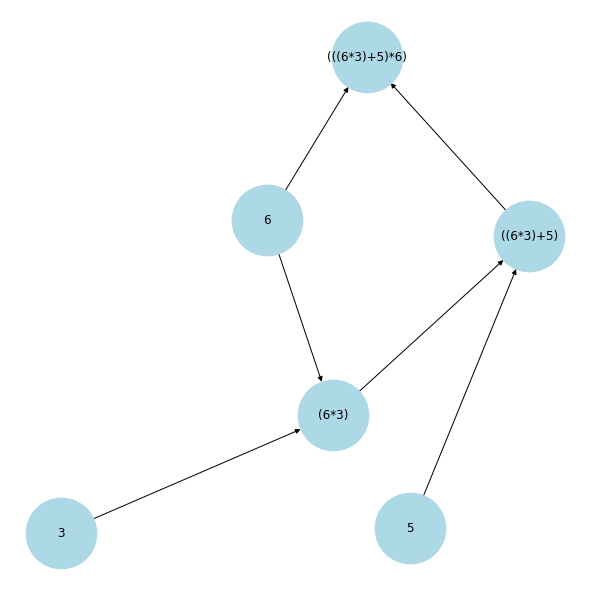

In [19]:
program('(d*(a+(b*d)))', {'a': 5, 'b': 3, 'c': 2, 'd': 6})

F = (2*(4+5))
F = 18


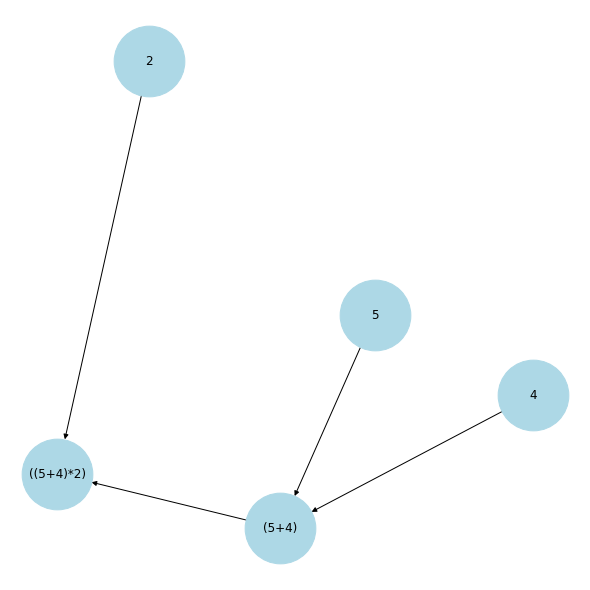

In [20]:
program('(2*(4+5))')
